## 10 Confusing XGBoost Hyperparameters and How to Tune Them Like a Pro in 2023
- https://towardsdatascience.com/10-confusing-xgboost-hyperparameters-and-how-to-tune-them-like-a-pro-in-2023-e305057f546

<div style="text-align: right"> <b>Author : Kwang Myung Yu</b></div>
<div style="text-align: right"> Initial upload: 2023.7.16</div>
<div style="text-align: right"> Last update: 2023.7.16</div>

In [2]:
import os
import sys
import time
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from scipy import stats
import warnings; warnings.filterwarnings('ignore')
#plt.style.use('ggplot')
plt.style.use('seaborn-whitegrid')
%matplotlib inline

XGboost는 모델을 복잡도와 일반화 성능(simplicity)의 균형을 맞추는 것이 매우 중요하다.   
다음 파라미터는 과접합을 제어하는데 매우 유용하다.   

- eta
- num_boost_round
- max_depth
- subsample
- colsample_bytree
- gamma
- min_child_weight
- lambda
- alpha

XGBoost API vs Sklearn API  
- XGBoost API가 유연성과 고급 기능 측면에서 약간의 이점을 제공
- 여기서는 XGBoost API를 기준으로 설명

다음 경로에 코드를 기록함  
- https://gist.github.com/BexTuychiev/823df08d2e3760538e9b931d38439a68

옵투나에 대해서는 다음 튜토리얼 참고
- https://towardsdatascience.com/why-is-everyone-at-kaggle-obsessed-with-optuna-for-hyperparameter-tuning-7608fdca337c

Xgboost와 sklearn api는 하이퍼파라미터 이름을 다르게 사용하고 있는데 각각의 이름과 튜닝 범위는 다음과 같다.   
옵투나가 아닌 다른 튜너를 사용할 경우 이표를 사용할 수 있다.

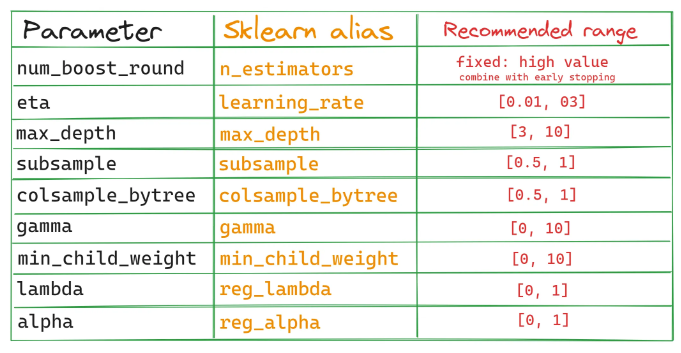

아래는 각 파라미터간 상호작용을 나타낸 표이다.

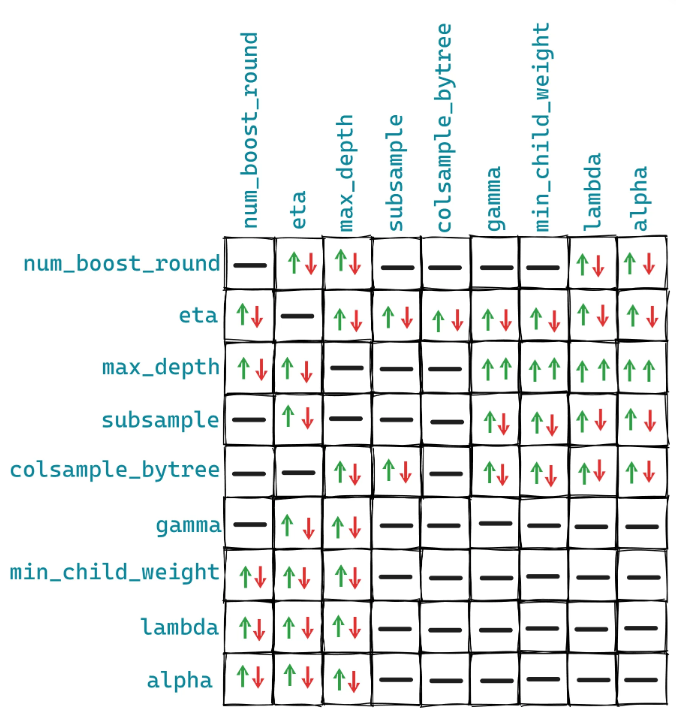

### Top 10 parameters

#### 0. objective : sklearn api에는 없음

먼저 objective 옵션으로 숲속의 path를 설정해야한다.

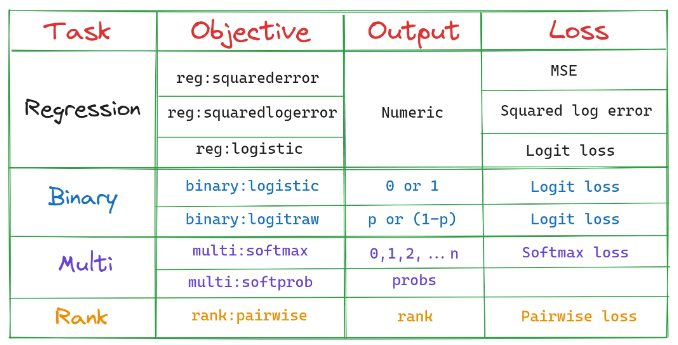

- objective는 결정 트리와 loss function 설정에 직접 영향을 미친다.

#### 1. num_boost_round : n_estimators(사이킷런)

결정 트리의 수이다. 기본 값은 100이지만 대규모 데이터셋에서는 충분하지 않을 수도 있다.  
트리수를 늘리면 복잡도는 높아지지만 과정합 가능성이 있다.   

캐글에서는 100,000과 같은 높은수로 설정한 뒤, early stopping을 설정하는 방법을 활용한다.   

그냥 num_boost_round를 설정하면 이전 라운드보다 개선되었는지에 관계없이 `num_boost_round`까지 계속된다.  
그러나 early stopping을 사용하면 5, 10, 50 또는 임의 라운드 동안 향상되지 않으면 학습을 중지하여 필요없는 트리를 생성하지 않는다.   

이렇게 하면 num_boost_round를 조정하지 않고 완벽하게 결정트리 수를 찾을 수 있고, 학습 시간과 계산 리소스도 줄일 수 있다.  
코드로 구현하면 다음과 같다.

```python
# Define the rest of the params
params = {...}

# Build the train/validation sets
dtrain_final = xgb.DMatrix(X_train, label=y_train)
dvalid_final = xgb.DMatrix(X_valid, label=y_valid)

bst_final = xgb.train(
    params,
    dtrain_final,
    num_boost_round=100000 # Set a high number
    evals=[(dvalid_final, "validation")],
    early_stopping_rounds=50, # Enable early stopping
    verbose_eval=False,
)
```

- 통상적으로 트리는 5000 ~ 10000개 선에서 만들어 지는듯 하다.  
- 트리가 많을 수록 많은 리소스가 필요하다.

#### 2. eta - learning_rate

예를 들어 각 round에서 부스팅 트리가 다음과 같이 예측 오차를 출력했다고 가정하자.  
Tree 1: 0.57  
Tree 2: 0.9  
Tree 3: 4.25  
Tree 4: 6.4  
Tree 5: 2.1  

이때 `eta`를 사용해서 영향도를 조정할 수 있다.  
- output = eta * (0.57 + 0.9 + 4.25 + 6.4 + 2.1)

eta, 즉 learning_rate가 높으면 각 트리 기여도에 큰 가중치를 부야하지만 과적합, 불안정을 유발한다. 대신 학습시간은 빠르다.  
반대로 작은 값이면 트리의 기여도가 약해져 학습 프로세스가 느려지지만 더 강력해진다.

eta는 num_boost_round, max_depth, subsample 및 colsample_bytree와 같은 다른 매개변수와 반비례 관계를 갖는다.  

eta가 낮으면 이러한 파라미터의 값이 높아져야 하고, 그 반대의 경우도 마찬가지이다.   
하지만 하이퍼파라미터 튜너가 최적의 조합을 찾아주기 때문에 이러한 파라미터 간의 상호 작용에 대해 걱정할 필요는 없다.

#### subsample and colsample_bytree

subsampling은 훈련에 더 많은 무작위성을 도입하여 과적합을 더 많이 방지하는 데 도움이 되는 배깅의 한 형태이다.   
subsample=0.7은 앙상블의 각 의사 결정 트리가 무작위로 선택된 사용 가능한 데이터의 70%에 대해 학습한다는 의미이다.   값이 1.0이면 모든 행이 사용됨(하위 샘플링 없음)을 나타낸다.

subsample과 유사하게 colsample_bytree도 있습니다. 이름에서 알 수 있듯이 colsample_bytree는 각 의사 결정 트리가 사용할 피처의 비율을 제어합니다. colsample_bytree=0.8은 각 트리에서 사용 가능한 피처(열)의 무작위 80%를 사용하도록 설정합니다.

이 두 매개 변수를 조정하면 편향과 분산 사이의 균형을 제어할 수 있습니다. 더 작은 값을 사용하면 트리 간의 상관관계가 줄어들고 앙상블의 다양성이 증가하여 일반화를 개선하고 과적합을 줄이는 데 도움이 될 수 있습니다.

그러나 더 많은 노이즈가 발생하고 모델의 편향성이 증가할 수도 있습니다. 반대로 더 큰 값을 사용하면 트리 간의 상관관계가 증가하여 다양성이 감소하고 잠재적으로 과적합이 발생할 수 있습니다.

#### 5. max_depth

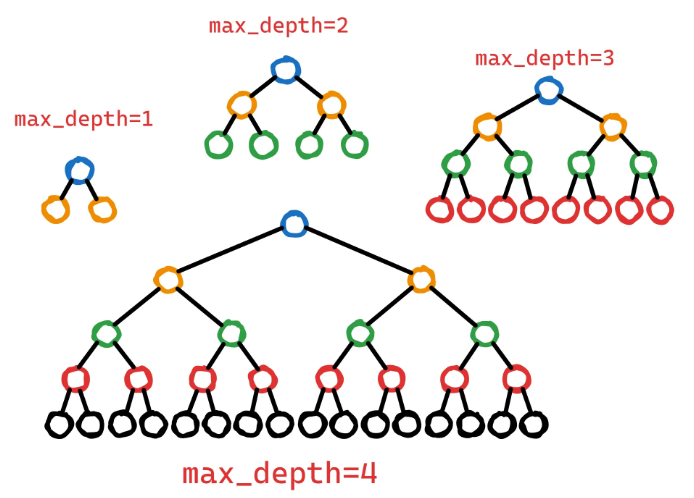

max_depth는 학습 중에 의사 결정 트리가 도달할 수 있는 최대 레벨 수를 제어합니다.

깊이가 깊은 트리는 특징 간의 복잡한 상호작용을 포착할 수 있습니다.  
그러나 트리가 깊을수록 훈련 데이터에서 노이즈나 관련 없는 패턴을 기억할 수 있으므로 과적합의 위험도 높아집니다.

이러한 복잡성을 제어하기 위해 최대 깊이를 제한하여 더 단순하고 더 일반적인 패턴을 포착하는 더 얕은 트리를 만들 수 있습니다.

max_depth는 복잡성과 일반화 사이의 균형을 잡아주는 훌륭한 매개 변수입니다.

#### 6, 7. alpha, lambda

alpha (L1)와 lambda (L2) 는 과적합을 막아주는 또다른 정규화 파라미터 이다.    

다른 정규화 매개변수와의 차이점은 중요하지 않은 특징의 가중치(특히 알파)를 0으로 축소하여 특징이 더 적도록 하여 복잡성이 적은 모델을 만들 수 있다는 점입니다.   

알파 및 람다의 효과는 최대 깊이, subsample 및 colsample_bytree와 같은 다른 매개 변수에 의해 영향을 받을 수 있습니다. 알파 또는 람다 값이 높으면 정규화 증가를 보정하기 위해 다른 매개변수를 조정해야 할 수 있습니다.  
예를 들어, 알파 값이 높을수록 모델 다양성을 유지하고 과소 적합을 방지하기 위해 더 큰 subsample 값이 유용할 수 있습니다.


#### 8. gamma

정규 문서에는 다음과 같이 나타나있다.   
`트리의 리프 노드에서 추가 파티션을 만드는 데 필요한 최소 손실 감소율입니다.`    

문장을 작성한 사람 외에는 이 문장이 이해가 되지 않는 것 같습니다. 문장을 분석해 보겠습니다.

다음은 두 가지 수준의 의사 결정 트리입니다:


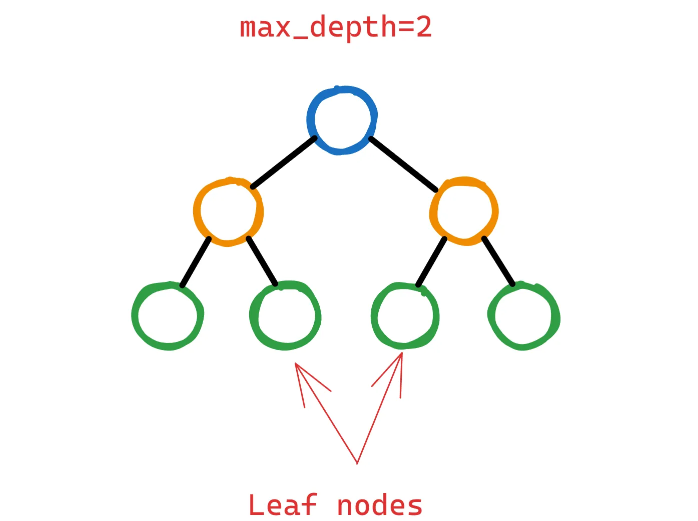

리프 노드를 분할하여 트리에 더 많은 레이어를 추가하는 것을 정당화하기 위해 XGBoost는 이 작업이 손실 함수를 크게 낮춰야 한다고 계산해야 합니다.

하지만 '얼마나 크게?"라고 질문할 수 있습니다. 감마는 리프 노드를 더 분할할지 여부를 결정하기 위한 임계값 역할을 합니다.

잠재적 분할 후 손실 함수(흔히 이득이라고 함)의 감소가 선택한 감마보다 작으면 분할이 수행되지 않습니다. 즉, 리프 노드는 동일하게 유지되고 트리는 그 시점부터 성장하지 않습니다.

따라서 감마 튜닝의 목표는 손실 함수를 가장 크게 감소시키는 최적의 분할을 찾는 것이며, 이는 모델 성능 향상을 의미합니다.
???

#### 9. min_child_weight

XGBoost는 단일 루트 노드가 있는 단일 의사 결정 트리로 초기 훈련 프로세스를 시작합니다.   
이 노드에는 처음에 모든 훈련 인스턴스(행)가 포함됩니다.  

그런 다음 XGBoost가 손실을 가장 크게 줄일 수 있는 잠재적 특징과 분할 기준을 선택함에 따라 더 깊은 노드에는 점점 더 적은 수의 인스턴스가 포함됩니다.

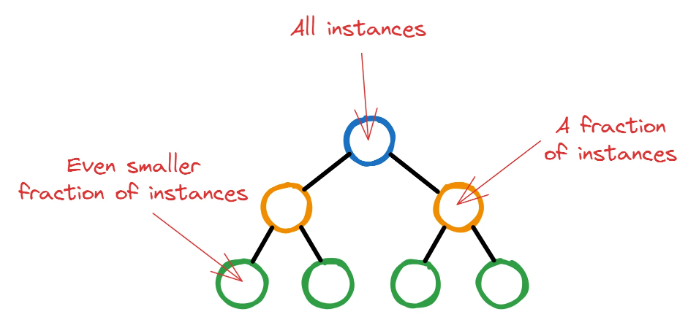

XGBoost를 과도하게 사용하면 최종 노드에 중요하지 않은 인스턴스 몇 개만 남을 정도로 트리가 커질 수 있습니다. 이러한 상황은 과적합의 정의에 해당하므로 매우 바람직하지 않습니다.  

그렇기 때문에 XGBoost는 사용자가 각 노드에서 분할을 계속할 수 있는 최소 인스턴스 수에 대한 임계값을 설정할 수 있도록 합니다. 이를 결정하기 위해 노드의 모든 인스턴스에 가중치를 부여하고 가중치의 합을 구합니다. 그런 다음 이 최종 가중치가 min_child_weight보다 작으면 분할이 중지되고 노드는 리프 노드가 됩니다.  

이 설명은 전체 프로세스를 지나치게 단순화한 것이지만, 일반적인 개념은 알 수 있을 것입니다.


### Conclusion

마지막으로 튜닝 후 모델 성능을 테스트할 때는 교차 검증과 깨끗한 최종 테스트 세트를 모두 사용해야 한다는 말을 남기고 싶습니다.

데이터를 80/20으로 분할하고 5~7배 CV로 80%에서 XGBoost를 튜닝한 후 최적의 파라미터를 찾으면 나머지 20%에서 최종적으로 성능을 측정할 수 있습니다. 이렇게 하면 최대한 강력한 결과를 얻을 수 있습니다.  

마지막으로 다음 코드를 확인바란다.

```python
import optuna
import xgboost as xgb
from sklearn.metrics import mean_squared_error # or any other metric
from sklearn.model_selection import train_test_split

# Load the dataset
X, y = ... # load your  own
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the objective function for Optuna
def objective(trial):
    # Define the search space for hyperparameters
    param = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'eta': trial.suggest_float('eta', 0.01, 0.3),
        'num_boost_round': 100000, # Fix the boosting round and use early stopping
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0.0, 10.0),
        'min_child_weight': trial.suggest_float('min_child_weight', 0.1, 10.0),
        'lambda': trial.suggest_float('lambda', 0.1, 10.0),
        'alpha': trial.suggest_float('alpha', 0.0, 10.0),
    }
    
    # Split the data into further training and validation sets (three sets are preferable)
    train_data, valid_data, train_target, valid_target = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
    
    # Convert the data into DMatrix format
    dtrain = xgb.DMatrix(train_data, label=train_target)
    dvalid = xgb.DMatrix(valid_data, label=valid_target)
    
    # Define the pruning callback for early stopping
    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, 'validation-rmse')
    
    # Train the model with early stopping
    model = xgb.train(param, dtrain, evals=[(dvalid, 'validation')], early_stopping_rounds=100, callbacks=[pruning_callback])
    
    # Make predictions on the test set
    dtest = xgb.DMatrix(valid_data)
    y_pred = model.predict(dtest)
    
    # Calculate the root mean squared error
    rmse = mean_squared_error(valid_test, y_pred, squared=False)
    
    return rmse

# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100) # Control the number of trials

# Print the best hyperparameters and the best RMSE
best_params = study.best_params
best_rmse = study.best_value
print("Best Hyperparameters: ", best_params)
print("Best RMSE: ", best_rmse)

#---------------------------------------------------------------------#
# You can also tune for multiple metrics. See here: https://stackoverflow.com/questions/69071684/how-to-optimize-for-multiple-metrics-in-optuna

```